In [183]:
import torch
import argparse
import math
import torch.nn as nn 
from torch.nn.functional import leaky_relu, softmax
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader
from collections import Counter

from GANutils import *
from utils import *
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from IPython.display import clear_output

In [9]:
cuda = torch.cuda.is_available()
device = torch.device("cuda:0" if cuda else "cpu")

In [11]:
data = pd.read_pickle('Data/TU_onehot')

In [ ]:
cat = Counter([v.split('_')[0] for v in list(data.columns)])
cat_total = sum(cat.values())
cat_n = list(cat.values())
INPUT_SIZE = 500

In [ ]:
def gen_noise(size:int, batch_size:int):
    '''
    Generates a 1-d vector of gaussian sampled random values
    '''
    n = Variable(torch.randn([batch_size,size]))
    return n



def softmax2onehot(x):
    x=x.to('cpu')
    max_idx = torch.argmax(x, 1, keepdim=True)
    one_hot = torch.FloatTensor(x.shape)
    one_hot.zero_()
    return one_hot.scatter_(1, max_idx, 1)

In [159]:
class Generator (nn.Module):
    def __init__(self, 
                 input_size: int, 
                 hidden_size: int, 
                 cat: Counter):
        super(Generator, self).__init__()
        self.cat = cat
        self.cat_n = list(cat.values())
        self.output_size = sum(self.cat.values())
        
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, hidden_size),
            nn.LeakyReLU(negative_slope=0.2),
            nn.BatchNorm1d(hidden_size, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.l2 = nn.Sequential( 
            nn.Linear(hidden_size, hidden_size * 2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.l3 = nn.Sequential( 
            nn.Linear(hidden_size*2, hidden_size * 3),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(hidden_size * 3, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.l4 = nn.Sequential( 
            nn.Linear(hidden_size * 3, self.output_size *2),
            nn.LeakyReLU(negative_slope = 0.2),
            nn.BatchNorm1d(self.output_size * 2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
        self.out = nn.Sequential( 
            nn.Linear(self.output_size *2, self.output_size)        )
        
    def forward(self,x):
        x=self.l1(x)
        x=self.l2(x)
        x=self.l3(x)
        x=self.l4(x)
        x=self.out(x)
        ### Sigmoid per class
        x = x.split(self.cat_n, dim=1)
        out = torch.cat([softmax(v, dim =1) for v in x], dim=1)
        return out
#G = Generator(input_size=INPUT_SIZE, hidden_size=1024, cat=cat)

In [164]:
class Discriminator(nn.Module):
    def __init__(self, input_size:int, output_size=1):
        super(Discriminator,self).__init__()
        
        self.l1 = nn.Sequential( 
            nn.Linear(input_size, 1024),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.l2 = nn.Sequential(
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.l3 = nn.Sequential(
            nn.Linear(512, 256),
            nn.LeakyReLU(0.2),
            nn.Dropout(0.3)
        )
        self.out = nn.Sequential(
            torch.nn.Linear(256, output_size),
            torch.nn.Sigmoid()
        )
        
    def forward(self, x):
        x = self.l1(x)
        x = self.l2(x)
        x = self.l3(x)
        x = self.out(x)
        return x

## Generator

In [228]:
class GAN():
    def __init__(self, 
                 data, 
                 cat, 
                 epochs = 1000,
                 batch_size=32,             #bad
                 gen_learn_rate=0.01,   #    0.05   0.05   0.01  
                 disc_learn_rate=10E-10): #   10E+8  10E-9  10E-10
        #Data
        self.cat = cat
        self.cat_n = list(cat.values())
        self.onehot_size = sum(self.cat.values())
        self.train_val_split(data, batch_size)
        
        #Networks
        self.G = Generator(input_size=INPUT_SIZE, hidden_size=2048, cat=self.cat)
        self.D = Discriminator(input_size=self.onehot_size)
        if(cuda):
            self.D = self.D.to(device)
            self.G = self.G.to(device)
        self.gen_learn_rate = gen_learn_rate
        self.disc_learn_rate = disc_learn_rate
        
        #Parameters
        self.epochs = epochs
        self.batch_size = batch_size
        self.gen_learn_rate = gen_learn_rate
        self.disc_learn_rate = disc_learn_rate
        
        #Optimizer
        self.loss = nn.BCELoss(reduction='sum')

        self.generator_optim = torch.optim.Adam(self.G.parameters(),
                                                gen_learn_rate, 
                                                eps = 10E-8, 
                                                betas=(0.6, 0.999)) #0.6
        self.discriminator_optim = torch.optim.Adam(self.D.parameters(), disc_learn_rate, betas=(0.4, 0.999))
        
    def train_val_split(self, data, batch_size):
        train, val = train_test_split(data, test_size=0.1)
        self.train = DataLoader(torch.tensor(train.values), 
                                                batch_size=batch_size, shuffle=True, num_workers=2)
        self.val  = DataLoader(torch.tensor(val.values), 
                                                batch_size=batch_size, shuffle=True, num_workers=2)
        
    def fit(self):
        discriminator_loss, generator_loss = [], []
        for epoch in range(self.epochs):
            batch_d_loss, batch_g_loss = [], []
            for x in self.val:
                if(cuda): x.to(device)
                batch_size = x.shape[0]
                # True data is given label 1, while fake data is given label 0
                true_label = torch.ones(batch_size, 1).to(device)
                fake_label = torch.zeros(batch_size, 1).to(device)
        
                self.D.zero_grad()
                self.G.zero_grad()
                
                # Step 0. First error propgation through Generator
                z = gen_noise(INPUT_SIZE, batch_size)
                z = Variable(z, requires_grad=False).to(device)
        
                x_fake = self.G.forward(z).to('cpu')
                x_fake = x_fake.split(self.cat_n, dim=1)
                x_fake = torch.cat([softmax2onehot(v) for v in x_fake], dim=1)
                x_fake = x_fake.to(device)
                
                output = self.D.forward(x_fake)
                error_generator = self.loss(output, true_label)
                error_generator.backward()
                self.generator_optim.step()
                self.D.zero_grad()
                self.G.zero_grad()
        
                
        
                # Step 1. Send real data through discriminator
                #         and backpropagate its errors.
                x_true = Variable(x).float()
                if cuda: x_true = x_true.to(device)
                output = self.D.forward(x_true)
        
                error_true = self.loss(output, true_label)
                error_true.backward()
        
                # Step 2. Generate fake data G(z), where z ~ N(0, 1)
                #         is a latent code.
                z = gen_noise(INPUT_SIZE, batch_size)
                z = Variable(z, requires_grad=False).to(device)
        
                x_fake = self.G.forward(z).to('cpu')
                x_fake = x_fake.split(self.cat_n, dim=1)
                x_fake = torch.cat([softmax2onehot(v) for v in x_fake], dim=1)
                x_fake = x_fake.to(device)
                # Step 3. Send fake data through discriminator
                #         propagate error and update D weights.
                # --------------------------------------------
                # Note: detach() is used to avoid compounding generator gradients
                output = self.D.forward(x_fake.detach()) 
        
                error_fake = self.loss(output, fake_label)
                error_fake.backward()
                self.discriminator_optim.step()
                
                # Step 4. Send fake data through discriminator _again_
                #         propagate the error of the generator and
                #         update G weights.
                output = self.D.forward(x_fake)
        
                error_generator = self.loss(output, true_label)
                error_generator.backward()
                self.generator_optim.step()
        
                batch_d_loss.append(((error_true + error_fake)/2).item())
                batch_g_loss.append(error_generator.item())
            clear_output()
            print("Epoch: %3d || D Loss: %5.5f || G Loss: %5.5f " %(epoch, np.mean(batch_d_loss), np.mean(batch_g_loss)))
            

            discriminator_loss.append(np.mean(batch_d_loss))
            generator_loss.append(np.mean(batch_g_loss))
            # -- Plotting --
            f, axarr = plt.subplots(1, 2, figsize=(18, 7))

            # Loss
            axarr[0].set_xlabel('Epoch')
            axarr[0].set_ylabel('Loss')
            axarr[0].set_title('Discriminator Loss || lr= %s' %self.disc_learn_rate )
            axarr[1].set_xlabel('Epoch')
            axarr[1].set_ylabel('Loss')
            axarr[1].set_title('Generator Loss  || lr= %s' %self.gen_learn_rate )

            axarr[0].plot(np.arange(epoch+1), discriminator_loss)
            axarr[1].plot(np.arange(epoch+1), generator_loss, linestyle="--")
            plt.show()
        

In [229]:
gan = GAN(data, cat)

Epoch:   8 || D Loss: 22.17092 || G Loss: 21.26612 


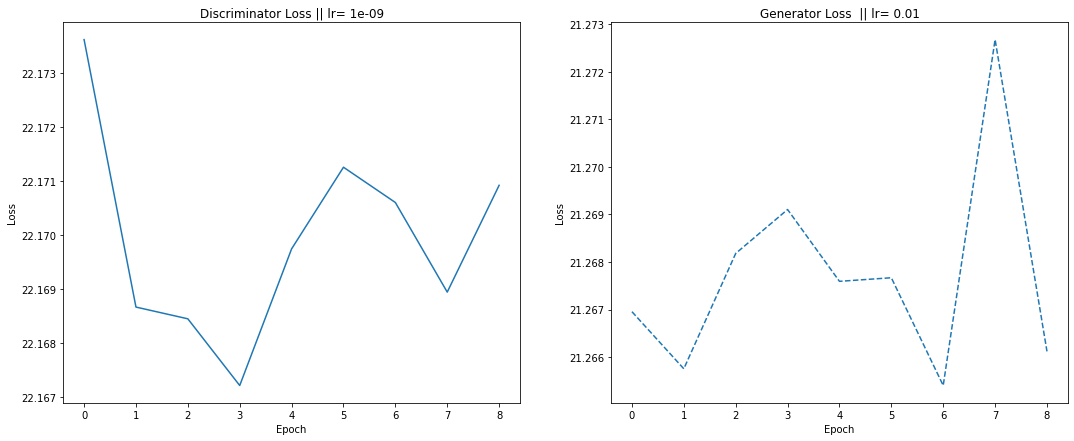

In [ ]:
gan.fit()